# Cargue de librerías

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt  
import json 
import requests
#import overpy
from tqdm import tqdm
from multiprocessing.dummy import Pool
import seaborn as sns
import re
from matplotlib.pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import tree
from __future__ import print_function
import sys
import datetime
import scipy as sp
# import more packages
#!pip install ax-platform
#https://ax.dev/docs/installation.html
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import render, init_notebook_plotting
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Análisis exploratorio de la base de datos

In [ ]:
# Se carga la base de datos de entrenamiento
base_train = pd.read_csv('base_train.csv', sep ='|')
base_train

In [ ]:
# Se observa que hay un total de 28 variables con 28.276 entradas o filas. Hay 2 variables de tipo entero, 1 variable
# objeto y las restantes son float64
base_train.info()

f_analisis  tipo_cliente
201801      adicion         1.000000
201802      adicion         1.000000
201803      adicion         1.000000
201804      adicion         1.000000
201805      adicion         1.000000
201806      adicion         1.000000
201807      adicion         1.000000
201808      adicion         1.000000
201809      adicion         1.000000
201810      adicion         0.620719
            objetivo        0.379281
201811      adicion         0.582698
            objetivo        0.417302
201812      adicion         0.587351
            objetivo        0.412649
Name: tipo_cliente, dtype: float64


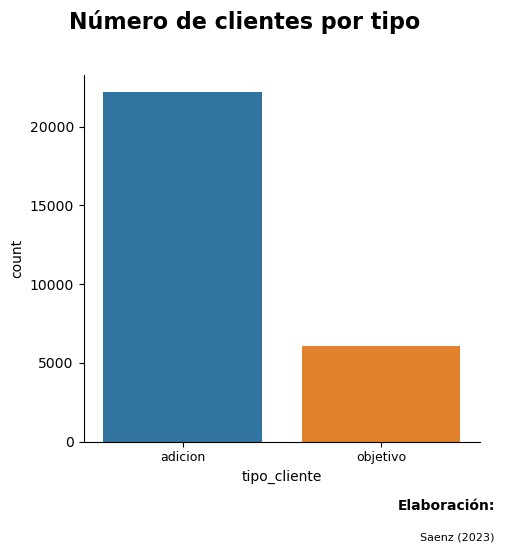

In [4]:
print(base_train.groupby('f_analisis')['tipo_cliente'].value_counts(True))
# Se observa que e 78% de los clientes aproximadamente son de tipo adicion
# tambien se observa que l0s clientes objetivo solamente estan presentes en los meses de octubre, noviembre y diciembre
g = sns.catplot(x = "tipo_cliente", kind = "count", data = base_train)
g.fig.suptitle("Número de clientes por tipo", fontsize = 16, fontweight = "bold")
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
plt.subplots_adjust(top=0.85)
g.fig.text(1,-.02, "Elaboración:", fontsize = 10, fontweight = "bold", ha = "right")
g.fig.text(1,-.08, "Saenz (2023)", fontsize = 8, ha = "right")
plt.show()

In [ ]:
# Se particiona la base en los clientes objetivo y clientes adicion
base_train_objetivo = base_train.loc[(base_train['tipo_cliente']=='objetivo')]
base_train_objetivo

In [ ]:
base_train_adicion = base_train.loc[(base_train['tipo_cliente']=='adicion')]
base_train_adicion

In [ ]:
# En esta descripción de variables se observa que, para los clientes objetivo, está desbalanceada la base de datos en la
# variable respuesta, mayormente hay valores cero "0" que identifica los clientes que cumplieron con el pago.
base_train_objetivo.describe()

In [ ]:
base_train_objetivo.drop('tipo_cliente', inplace=True, axis=1)
base_train_objetivo.drop('num_doc', inplace=True, axis=1)
base_train_objetivo.drop('f_analisis', inplace=True, axis=1)
# Se eliminan las variables que no se incluyen en el análisis
base_train_objetivo.info()

# Análisis de correlación, anova y selección de características

In [18]:
base_train = pd.read_csv('base_train.csv', sep="|") 
base_train = base_train.loc[(base_train['tipo_cliente']=='objetivo')]
num_doc_train = base_train['num_doc']
base_train = base_train.drop(['num_doc', 'f_analisis', 'tipo_cliente'], axis=1)
base_train

,default,trx39,trx102,trx106,trx143,trx158,disp309,CO01END010RO,CO01ACP017CC,CO02EXP011TO,...,CO01END086RO,CO01END094RO,CO02NUM086AH,CO02NUM043RO,CO01EXP002AH,CO01NUM002AH,CO01END051RO,CO01ACP011RO,CO02MOR092TO,CO01MOR098RO
5,0,0.000000,0.000000,0.000000,0.000000,0.000000,12.0,0.57,9.0,75.00,...,76.97,1.92,-1.00,25.00,-1.0,-1.0,1.16,0.0,100.00000,95.946045
9,0,0.000000,0.000001,0.000001,0.000000,0.000000,7.0,0.65,12.0,75.00,...,53.64,4.48,50.00,50.00,12.0,2.0,5.70,1.0,100.00000,100.000000
12,0,1.105542,0.000000,0.000000,0.707554,0.213336,8.0,0.15,140.0,85.71,...,87.80,6.40,57.14,50.00,3.0,4.0,-4.00,0.0,91.81353,-3.000000
18,0,0.276385,0.000000,0.000000,0.000000,0.002133,7.0,-1.00,-2.0,83.33,...,-1.00,-1.00,50.00,-1.00,0.0,3.0,-1.00,-1.0,100.00000,-1.000000
21,0,0.276385,0.000005,0.000000,0.000000,0.039467,6.0,0.34,95.0,36.36,...,90.45,5.31,36.36,50.00,0.0,4.0,7.90,1.0,100.00000,89.226580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28245,0,0.000000,0.000000,0.000000,0.000000,0.000000,12.0,-1.00,-1.0,-1.00,...,-1.00,-1.00,-3.00,-1.00,-1.0,-1.0,-1.00,-1.0,-1.00000,-1.000000
28249,0,0.829156,0.012800,0.003840,0.424532,0.097068,7.0,0.89,-1.0,33.33,...,16.44,2.56,33.33,33.33,2.0,2.0,0.01,0.0,100.00000,100.000000
28254,0,0.276385,0.000000,0.000000,0.000000,0.008533,8.0,2.33,4.0,77.78,...,47.28,4.28,44.44,0.00,19.0,4.0,2.18,-2.0,100.00000,100.000000
28261,0,0.276385,0.000000,0.000000,0.000000,0.008533,8.0,7.83,98.0,62.50,...,1.57,14.72,37.50,0.00,2.0,3.0,0.00,-2.0,100.00000,100.000000


In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
result_anova_default = []
significancia_default = []
for i,x in enumerate(base_train.iloc[:,1:].columns.values.tolist()):
    model = ols('default' + '~' + x, data = base_train).fit()
    result_anova_default.append(sm.stats.anova_lm(model))
    significancia_default.append(result_anova_default[i]['PR(>F)'][0])
pvalue_default = pd.concat([pd.DataFrame(base_train.iloc[:,1:].columns), pd.DataFrame(significancia_default)], axis=1)
pvalue_default.columns = ['column_name', 'pvalor']
pvalue_default = pvalue_default.sort_values(by='pvalor', ascending=True)
pvalue_default

# En este anova se observa la prueba de hipotesis de igualdad de grupo, si hay o no correlación entre la variable respuesta
# y las independientes. Se observa que las variables ['CO02MOR092TO', 'CO01END010RO', 'disp309', 'CO01MOR098RO',
#'CO02NUM043RO', 'CO01EXP003RO', 'CO01END094RO', 'CO02EXP011TO', 'CO01ACP011RO', 'CO01EXP001CC', 'CO01NUM002AH',
#'CO01ACP017CC', 'trx143', 'CO02END015CC','CO01END002RO','CO01END051RO'] rechazan la hipótesis nula de igualdad de varianzas
# y por tanto hay asociación con la variable respuesta.

,column_name,pvalor
22,CO02MOR092TO,3.307712e-19
6,CO01END010RO,1.405368e-14
5,disp309,6.991203e-12
23,CO01MOR098RO,5.410833e-10
17,CO02NUM043RO,2.825569e-08
11,CO01EXP003RO,2.321485e-07
15,CO01END094RO,2.326886e-06
8,CO02EXP011TO,2.546842e-06
21,CO01ACP011RO,1.491166e-05
10,CO01EXP001CC,8.871088e-05


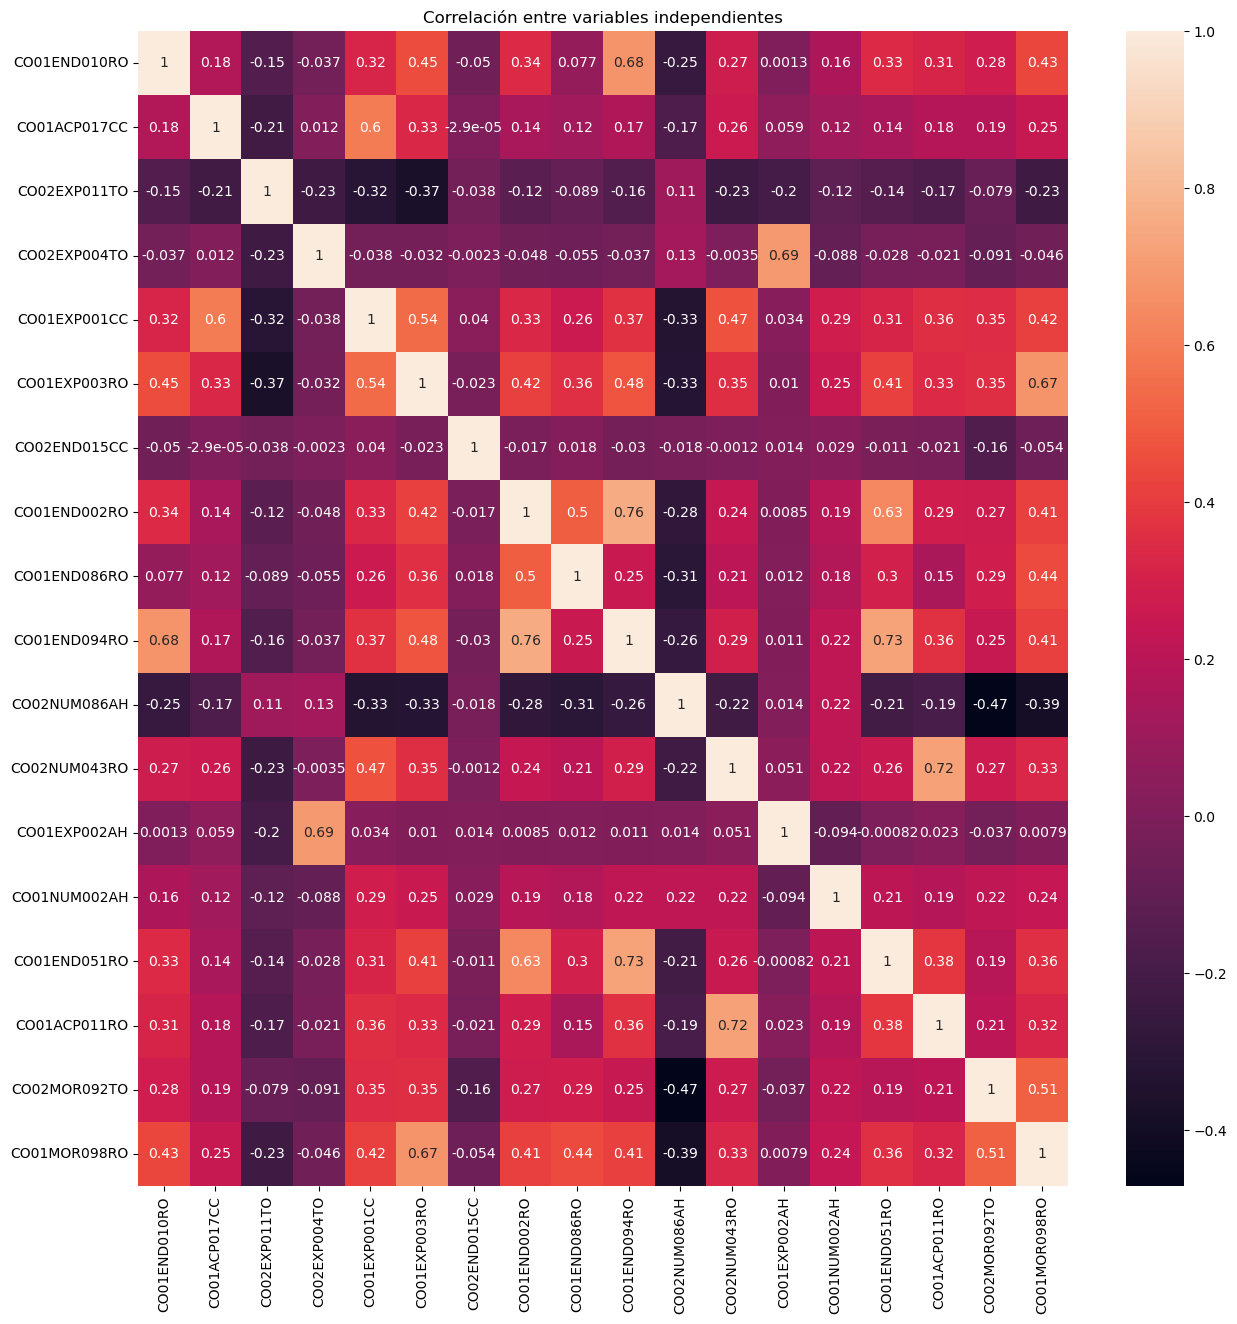

In [20]:
plt.figure(figsize=(15, 15))
sns.heatmap(base_train.iloc[:,7:].corr(method='pearson'), annot=True)
plt.title('Correlación entre variables independientes')
plt.show()
# En este gráfico de correlaciones se observa como hay variables que presentan asociación alta con otras variables
# explicativas. Por ejemplo entre CO01END010RO y CO01END094RO de un 0,68 ya que ambas se refieren del cupo a la fecha.
# También CO01EXP002AH y CO02EXP004TO de 0,69 ya que ambas se refieren a meses de apertura de algún producto.

## Modelo de xgBoost para seleccion de variables

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [22]:
# Debido a que la variable respuesta está desbalanceada entonces se procede a balancear
#Toma el valor de uno cuando el cliente incumplió el pago de su obligación.
#Toma el valor de cero cuando el cliente cumplió con el pago.
case_0 = base_train[base_train['default']==0]
case_1 = base_train[base_train['default']==1]

case_1_upsample = resample(case_1, replace=True, n_samples=len(case_0), random_state=25)
base_train_desbalanc = base_train.copy()
base_train=pd.concat([case_0, case_1_upsample])
print(base_train['default'].value_counts())

0    5548
1    5548
Name: default, dtype: int64


In [23]:
# SE carga la base de validación que sirve como base de prueba
base_prueba = pd.read_csv('base_validacion.csv', sep="|")
num_doc_prueba = base_prueba['num_doc']
base_prueba = base_prueba.drop(['num_doc', 'f_analisis', 'tipo_cliente'], axis=1)
base_prueba

,default,trx39,trx102,trx106,trx143,trx158,disp309,CO01END010RO,CO01ACP017CC,CO02EXP011TO,...,CO01END086RO,CO01END094RO,CO02NUM086AH,CO02NUM043RO,CO01EXP002AH,CO01NUM002AH,CO01END051RO,CO01ACP011RO,CO02MOR092TO,CO01MOR098RO
0,0,0.000000,0.000000,0.000000,0.017689,0.000000,8,4.76,-2,90.00,...,19.29,8.96,30.00,28.57,7,3,6.48,0,100.0,100.000000
1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,8.73,1,92.31,...,38.15,15.36,14.29,64.29,15,2,4.55,2,100.0,100.000000
2,0,0.000000,0.000000,0.000000,0.044807,0.000000,8,0.65,-1,100.00,...,34.15,1.73,40.00,0.00,5,2,0.00,-2,100.0,100.000000
3,0,1.027402,0.256003,0.000001,0.251293,0.330670,8,-2.00,1,57.14,...,-3.00,-2.00,14.29,100.00,3,1,1.49,1,100.0,44.882557
4,0,0.276385,0.000000,0.000000,0.000000,0.010667,6,0.31,-1,100.00,...,71.58,0.38,33.33,0.00,2,1,0.76,-2,-3.0,-3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,0,0.000000,0.000000,0.000000,0.000000,0.000000,6,1.53,-1,75.00,...,0.00,1.53,75.00,0.00,15,3,0.00,-2,100.0,100.000000
2064,0,0.000000,0.000000,0.000000,0.035378,0.000000,6,2.90,-1,100.00,...,13.03,3.84,38.46,85.71,11,5,1.02,0,100.0,100.000000
2065,0,0.000000,0.000000,0.000000,0.000000,0.000000,6,-3.00,-2,60.00,...,108.32,5.50,20.00,0.00,65,1,5.35,-2,100.0,100.000000
2066,0,0.645497,0.000001,0.000012,0.239469,0.168535,6,0.21,2,100.00,...,62.68,1.28,50.00,0.00,3,3,1.66,-2,100.0,98.185800


In [24]:
##### Seleccionar bases de entrenamiento y prueba
X_train = base_train.drop('default', axis=1)
X_test = base_prueba.drop('default', axis=1)
y_train = base_train['default']
y_test = base_prueba['default']

# Adicionalmente se van a escalar variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape, X_test_scaled.shape)

(11096, 24) (2068, 24)


In [ ]:
# Acá se propone un modelo xgboost para observar que variables son las más importantes y, en caso de observarse, seleccionar
# algunas variables importantes. Se utiliza una grilla de parámetros para encontrar la mejor combinación de hiperparámetros
# que maximice el f1 score
from sklearn.metrics import accuracy_score
classifier_xg = XGBClassifier()
gamma = [0.5,1,2,3,4,5,6,7,8,9,10]
n_estimators = [10, 20, 50, 100, 200]
max_depth = [10, 15, 20, 40, 50]
booster=['gbtree','gblinear']
learning_rate=[0.001,0.01,0.05,0.1,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]
# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score,
    'gamma':gamma
    }
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=classifier_xg, param_distributions=hyperparameter_grid, cv=5, n_iter=50,
            scoring = 'f1',n_jobs = -1, verbose = 2, return_train_score = True, random_state=25)
random_cv.fit(X_train_scaled,y_train)
random_cv.best_estimator_

In [26]:
print("Best: %f using %s" % (random_cv.best_score_, random_cv.best_params_))
#random_cv.best_estimator_

Best: 0.958947 using {'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 50, 'learning_rate': 0.1, 'gamma': 3, 'booster': 'gbtree', 'base_score': 0.5}


In [27]:
# una vez se encontró la mejor combinación de hiperparámetros se procede a estimar el modelo
#mod_xgb = XGBClassifier(learning_rate=0.2, n_estimators=10, objective='binary:logistic',
#                        nthread=-1, colsample_bytree=0.8, gamma=3,
#                        max_depth=40, min_child_weight=1, subsample=1.0, booster='gbtree', base_score=0.25)
mod_xgb = random_cv.best_estimator_
mod_xgb.fit(X_train_scaled,y_train)
pred_xgb = mod_xgb.predict(X_test_scaled)
score_xgb = mod_xgb.score(X_test_scaled, y_test)
print(score_xgb)

0.8849129593810445


In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred_xgb)

array([[1809,  109],
       [ 129,   21]], dtype=int64)

In [29]:
print(classification_report(y_test,pred_xgb))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1918
           1       0.16      0.14      0.15       150

    accuracy                           0.88      2068
   macro avg       0.55      0.54      0.54      2068
weighted avg       0.88      0.88      0.88      2068



In [30]:
importances1 = mod_xgb.feature_importances_
importances_df1 = pd.DataFrame({'importances':importances1,'feauture':base_train.drop('default', axis=1).columns})
importances_df1 = importances_df1.sort_values(by=['importances'],ascending=False)
importances_df1

,importances,feauture
6,0.099571,CO01END010RO
2,0.054075,trx106
22,0.049280,CO02MOR092TO
12,0.048894,CO02END015CC
11,0.046369,CO01EXP003RO
13,0.045333,CO01END002RO
14,0.045062,CO01END086RO
15,0.042034,CO01END094RO
5,0.041903,disp309
20,0.040519,CO01END051RO


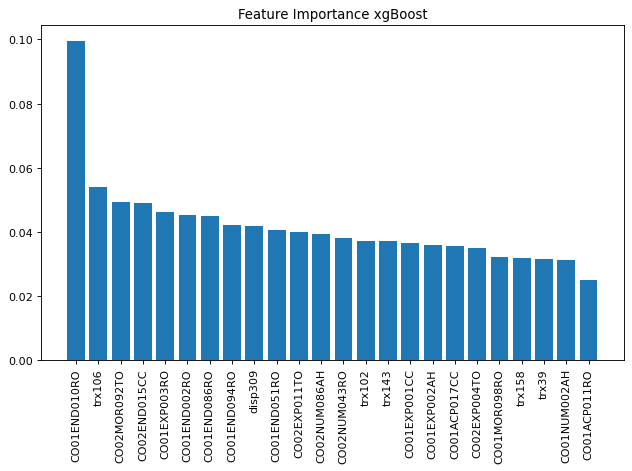

In [31]:
# Tanto en la tabla de arriba como el gráfico de abajo se observa que las variables presentan una importancia en explicar
# el cumplimiento de la obligación. Por tanto se van a conservar todas

sorted_indices0 = np.argsort(importances1)[::-1]
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Feature Importance xgBoost')
plt.bar(range(base_train.drop('default', axis=1).shape[1]), importances1[sorted_indices0], align='center')
plt.xticks(range(base_train.drop('default', axis=1).shape[1]),
           base_train.drop('default', axis=1).columns[sorted_indices0], rotation=90)
plt.tight_layout()
plt.show()

# Modelos de machine learning

In [32]:
base_train = pd.read_csv('base_train.csv', sep="|") 
base_train = base_train.loc[(base_train['tipo_cliente']=='objetivo')]
num_doc_train = base_train['num_doc']
base_train = base_train.drop(['num_doc', 'f_analisis', 'tipo_cliente'], axis=1)

base_prueba = pd.read_csv('base_validacion.csv', sep="|")
num_doc_prueba = base_prueba['num_doc']
base_prueba = base_prueba.drop(['num_doc', 'f_analisis', 'tipo_cliente'], axis=1)

##### Seleccionar bases de entrenamiento y prueba
X_train = base_train.drop('default', axis=1)
X_test = base_prueba.drop('default', axis=1)
y_train = base_train['default']
y_test = base_prueba['default']

# Escalar variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape, X_test_scaled.shape)

(6102, 24) (2068, 24)


## Regresión logística

In [33]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_scaled, y_train)

LogisticRegression()

In [34]:
pred_logisticRegr = logisticRegr.predict(X_test_scaled)
score_lr = logisticRegr.score(X_test_scaled, y_test)
print(score_lr)

0.9264990328820116


In [35]:
pd.DataFrame(pred_logisticRegr).value_counts()/pd.DataFrame(pred_logisticRegr).shape[0]

0    0.999033
1    0.000967
dtype: float64

In [ ]:
##### Se realiza la construcción de una grilla de parámetros 
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=25)
model_lr = LogisticRegression(random_state=25)
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['tol'] = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
grid_lr = GridSearchCV(model_lr, space, scoring='f1', n_jobs=-1, cv=cv)
logisticRegr = grid_lr.fit(X_train_scaled, y_train)
# summarize result
print('Best Score: %s' % logisticRegr.best_score_)
print('Best Hyperparameters: %s' % logisticRegr.best_params_)

In [37]:
logisticRegr = logisticRegr.best_estimator_
pred_logisticRegr = logisticRegr.predict(X_test_scaled)
score_lr = logisticRegr.score(X_test_scaled, y_test)
print(score_lr) # La precisión se mantuvo igual.

0.9264990328820116


In [38]:
#probabilidad de incumplimiento esperada por grupo, es decir que es default==1
pred_prob_logisticRegr = logisticRegr.predict_proba(X_test_scaled)
pd.DataFrame(pred_prob_logisticRegr).mean() # debería ser más desbalanceado

0    0.912793
1    0.087207
dtype: float64

In [40]:
base_prueba['default'].value_counts()/base_prueba.shape[0]

0    0.927466
1    0.072534
Name: default, dtype: float64

In [39]:
prob_incum_logistic = pd.DataFrame(pred_prob_logisticRegr[:,1:])

In [41]:
bins = [0, 0.010, 0.015, 0.030, 0.045, 0.080, 0.150, 0.300, 1.0]
names = ["T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8"]
prob_incum_logistic['Grupo_de_Riesgo'] = pd.cut(prob_incum_logistic[0], bins,labels = names)
prob_incum_logistic['Grupo_de_Riesgo'].value_counts().sort_index()

T1     51
T2     41
T3    131
T4    196
T5    679
T6    714
T7    252
T8      4
Name: Grupo_de_Riesgo, dtype: int64

In [42]:
## Estos son los resultados de la regresión logística por grupo de riesgo.

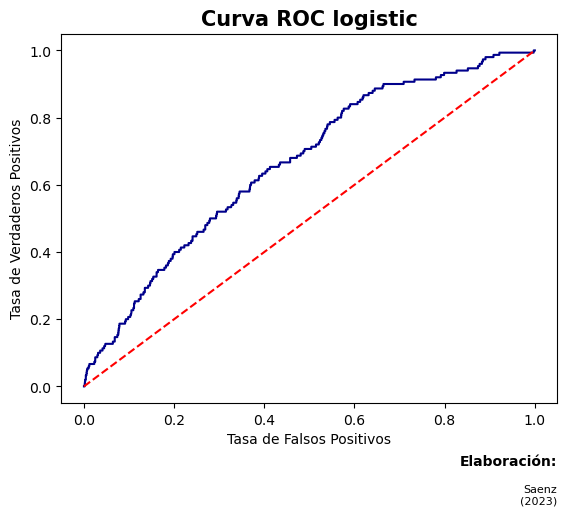

In [43]:
logit_roc_auc = roc_auc_score(y_test, pred_logisticRegr)
FP, VP, umbral = roc_curve(y_test, logisticRegr.predict_proba(X_test_scaled)[:,1])
fig, ax = plt.subplots()
ax.plot(FP, VP, color = "darkblue")
ax.plot([0,1], [0,1], linestyle = "--", color = "red")
ax.set_xlabel("Tasa de Falsos Positivos")
ax.set_ylabel("Tasa de Verdaderos Positivos")
ax.set_title("Curva ROC logistic", fontweight = "bold", size = 15)
fig.text(.9,-.02, "Elaboración:", fontsize = 10, fontweight = "bold",
         ha = "right")
fig.text(.9,-.1, "Saenz\n(2023)", fontsize = 8, ha = "right")
plt.show()

## Random Forest

In [44]:
rf = RandomForestClassifier(n_estimators=30, max_depth=10)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, n_estimators=30)

In [45]:
pred_rf = rf.predict(X_test_scaled)
score_rf = rf.score(X_test_scaled, y_test)
print(score_rf)

0.9269825918762089


In [46]:
pd.DataFrame(pred_rf).value_counts()/pd.DataFrame(pred_rf).shape[0]

0    0.999516
1    0.000484
dtype: float64

In [47]:
pred_rf = rf.predict(X_test_scaled)
# La precisión es igual que el modelo logístico, se construye una grilla de parámetros para ver si mejora

In [48]:
n_estimators =  [10,15,20,25,30,35,40,45,50,55,60,65,70,75]
max_depth = [10,15,20,21,24,25]
min_samples_split = [1, 2, 3, 5, 10]
min_samples_leaf = [1, 2, 3, 5, 10]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }

In [ ]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = 5, verbose = 2, scoring='accuracy')
rf_cv = grid_search.fit(X_train_scaled, y_train)

In [50]:
mod_rf = grid_search.best_estimator_
pred_rf = mod_rf.predict(X_test_scaled)
score_rf = mod_rf.score(X_test_scaled, y_test)
print(score_rf) # Mejoró la precisión

0.9264990328820116


In [51]:
pd.DataFrame(pred_rf).value_counts()/pd.DataFrame(pred_rf).shape[0]
# Está desbalanceada la predicción, hay que mirar como se comporta con las probabilidades.

0    0.999033
1    0.000967
dtype: float64

In [52]:
base_prueba['default'].value_counts()/base_prueba.shape[0]

0    0.927466
1    0.072534
Name: default, dtype: float64

In [53]:
#probabilidad de incumplimiento esperada por grupo, es decir que es default==1
pred_prob_rf = grid_search.predict_proba(X_test_scaled)
pd.DataFrame(pred_prob_rf).mean() # debería ser más desbalanceado, aunque tiene un buen comportamiento

0    0.909232
1    0.090768
dtype: float64

In [54]:
prob_incum_rf = pd.DataFrame(pred_prob_rf[:,1:])
prob_incum_rf['Grupo_de_Riesgo'] = pd.cut(prob_incum_rf[0], bins, labels = names)
prob_incum_rf['Grupo_de_Riesgo'].value_counts().sort_index()

T1     85
T2     53
T3    202
T4    200
T5    500
T6    687
T7    326
T8     15
Name: Grupo_de_Riesgo, dtype: int64

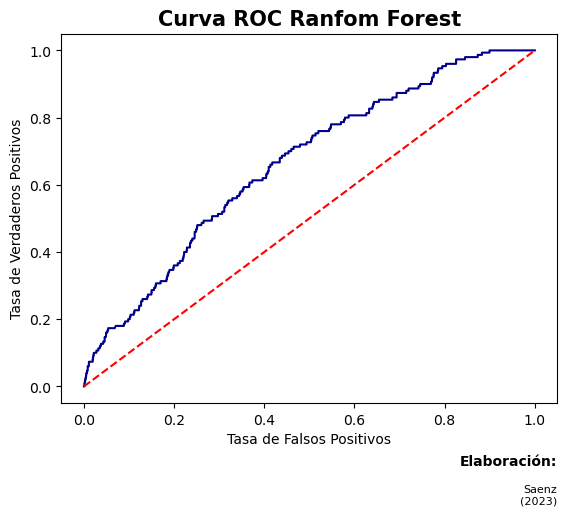

In [55]:
rf_roc_auc = roc_auc_score(y_test, pred_rf)
FP, VP, umbral = roc_curve(y_test, grid_search.predict_proba(X_test_scaled)[:,1])
fig, ax = plt.subplots()
ax.plot(FP, VP, color = "darkblue")
ax.plot([0,1], [0,1], linestyle = "--", color = "red")
ax.set_xlabel("Tasa de Falsos Positivos")
ax.set_ylabel("Tasa de Verdaderos Positivos")
ax.set_title("Curva ROC Ranfom Forest", fontweight = "bold", size = 15)
fig.text(.9,-.02, "Elaboración:", fontsize = 10, fontweight = "bold",
         ha = "right")
fig.text(.9,-.1, "Saenz\n(2023)", fontsize = 8, ha = "right")
plt.show()

## k nearest neighbor

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_scaled, y_train)
score_knn = knn.score(X_test_scaled, y_test)
print(score_knn)

In [ ]:
pred_knn = knn.predict(X_test_scaled)
cm = metrics.confusion_matrix(y_test, pred_knn)
print(cm)

In [58]:
pd.DataFrame(pred_knn).value_counts()/pd.DataFrame(pred_knn).shape[0]
# Está desbalanceada la predicción

0    0.983075
1    0.016925
dtype: float64

In [59]:
base_prueba['default'].value_counts()/base_prueba.shape[0]

0    0.927466
1    0.072534
Name: default, dtype: float64

In [60]:
# Se construye una grilla de parámetros
#n_neighbors = list(range(1,30))
#weights = ['uniform','distance']
#algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
#leaf_size = list(range(1,50))
#p=[1,2]
#metric = ['minkowski','euclidean','manhattan']
#param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, weights=weights,
#                  algorithm=algorithm, metric=metric)
param_grid = [{'n_neighbors': range(1,20,1),}]
knn_cv_roc = GridSearchCV(KNeighborsClassifier(), param_grid = param_grid,
                  scoring='accuracy',
                  refit=True,
                  cv=10,
                  verbose=1,
                  n_jobs=-1)
knn_cv_roc.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 19 candidates, totalling 190 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': range(1, 20)}], scoring='accuracy',
             verbose=1)

In [ ]:
mod_knn = knn_cv_roc.best_estimator_
score_knn = mod_knn.score(X_test_scaled, y_test)
print(score_knn)

In [ ]:
pred_knn = mod_knn.predict(X_test_scaled)
cm = metrics.confusion_matrix(y_test, pred_knn)
print(cm)

In [63]:
pd.DataFrame(pred_knn).value_counts()/pd.DataFrame(pred_knn).shape[0]
# Está bastante desbalanceado, hay que mirar como se comporta con la probabilidad

0    0.998549
1    0.001451
dtype: float64

In [64]:
base_prueba['default'].value_counts()/base_prueba.shape[0]

0    0.927466
1    0.072534
Name: default, dtype: float64

In [65]:
#probabilidad de incumplimiento esperada por grupo, es decir que es default==1
pred_prob_knn = mod_knn.predict_proba(X_test_scaled)
pd.DataFrame(pred_prob_knn).mean()
# Mejora bastante cuando se predice por probabilidad.

0    0.918866
1    0.081134
dtype: float64

In [66]:
prob_incum_knn = pd.DataFrame(pred_prob_knn[:,1:])

In [67]:
prob_incum_knn['Grupo_de_Riesgo'] = pd.cut(prob_incum_knn[0], bins, labels = names)
prob_incum_knn['Grupo_de_Riesgo'].value_counts().sort_index()

T1      0
T2      0
T3      0
T4      0
T5    664
T6    389
T7    196
T8     45
Name: Grupo_de_Riesgo, dtype: int64

In [68]:
## Estos son los resultados del KNN por grupo de riesgo. No le fue tan bien ya que en los primeros 4 grupos
## no se presentan datos

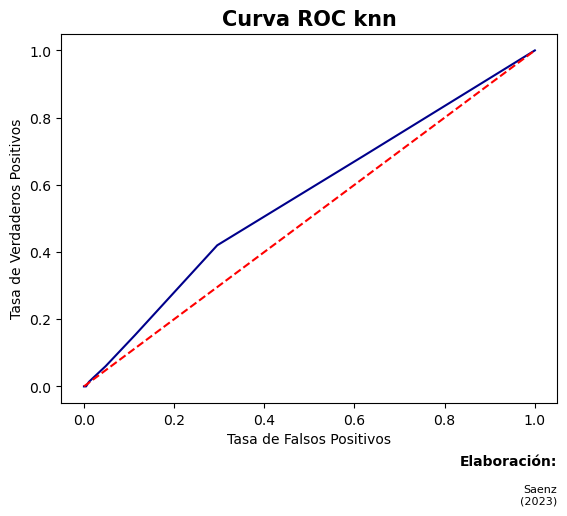

In [69]:
knn_roc_auc = roc_auc_score(y_test, pred_knn)
FP, VP, umbral = roc_curve(y_test, knn_cv_roc.predict_proba(X_test_scaled)[:,1])
fig, ax = plt.subplots()
ax.plot(FP, VP, color = "darkblue")
ax.plot([0,1], [0,1], linestyle = "--", color = "red")
ax.set_xlabel("Tasa de Falsos Positivos")
ax.set_ylabel("Tasa de Verdaderos Positivos")
ax.set_title("Curva ROC knn", fontweight = "bold", size = 15)
fig.text(.9,-.02, "Elaboración:", fontsize = 10, fontweight = "bold",
         ha = "right")
fig.text(.9,-.1, "Saenz\n(2023)", fontsize = 8, ha = "right")
plt.show()

## Support Vector Machine

In [97]:
svc = SVC(probability=True)
svc.fit(X_train_scaled, y_train)
score_svm = svc.score(X_test_scaled, y_test)
print(score_svm)

0.9274661508704062


In [98]:
pred_svm = svc.predict(X_test_scaled)
cm = metrics.confusion_matrix(y_test, pred_svm)
print(cm)

[[1918    0]
 [ 150    0]]


In [84]:
### Definir una grilla de parámetros para SVC
svc = SVC() 
parameters = [ {'C':[1, 3, 8, 10], 'kernel':['linear']},
               {'C':[1, 3, 8, 10], 'kernel':['rbf'], 
                'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 3, 8, 10], 'kernel':['poly'], 'degree': [2,3,4],
                'gamma':[0.01,0.02,0.03,0.04,0.05]}
              ]

grid_search_svm = GridSearchCV(estimator = svc,
                               param_grid = parameters,
                               scoring = 'accuracy',
                               cv = 2,
                               verbose=0)

grid_search_svm.fit(X_train_scaled, y_train)

GridSearchCV(cv=2, estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': [1, 3, 8, 10], 'kernel': ['linear']},
                         {'C': [1, 3, 8, 10],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [1, 3, 8, 10], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['poly']}],
             scoring='accuracy')

In [99]:
grid_search_svm.best_estimator_

In [86]:
score_svm = grid_search_svm.score(X_test_scaled, y_test)
print(score_svm) # Estuvo mejor la precisión con los parámetros por default

0.9264990328820116


In [87]:
pd.DataFrame(pred_svm).value_counts()/pd.DataFrame(pred_svm).shape[0]
base_prueba['default'].value_counts()/base_prueba.shape[0]

0    0.927466
1    0.072534
Name: default, dtype: float64

In [100]:
#probabilidad de incumplimiento esperada por grupo, es decir que es default==1
pred_prob_svm = svc.predict_proba(X_test_scaled)
pd.DataFrame(pred_prob_svm).mean() # Presenta un buen comportamiento en las probabilidades.

In [ ]:
prob_incum_svm = pd.DataFrame(pred_prob_svm[:,1:])

In [ ]:
prob_incum_svm['Grupo_de_Riesgo'] = pd.cut(prob_incum_svm[0], bins, labels = names)
prob_incum_svm['Grupo_de_Riesgo'].value_counts().sort_index()

In [ ]:
## Estos son los resultados del SVM por grupo de riesgo. No le fue tan bien ya que en los primeros 3 grupos
## no se presentan datos

In [ ]:
svm_roc_auc = roc_auc_score(y_test, pred_svm)
FP, VP, umbral = roc_curve(y_test, svc.predict_proba(X_test_scaled)[:,1])
fig, ax = plt.subplots()
ax.plot(FP, VP, color = "darkblue")
ax.plot([0,1], [0,1], linestyle = "--", color = "red")
ax.set_xlabel("Tasa de Falsos Positivos")
ax.set_ylabel("Tasa de Verdaderos Positivos")
ax.set_title("Curva ROC svm", fontweight = "bold", size = 15)
fig.text(.9,-.02, "Elaboración:", fontsize = 10, fontweight = "bold",
         ha = "right")
fig.text(.9,-.1, "Saenz\n(2023)", fontsize = 8, ha = "right")
plt.show()

## Red neuronal

### Primera red neuronal

In [101]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [102]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=20)

Epoch 1/20
191/191 [==============================] - 4s 3ms/step - loss: 0.6617 - accuracy: 0.7270
Epoch 2/20
191/191 [==============================] - 1s 4ms/step - loss: 0.4003 - accuracy: 0.9092
Epoch 3/20
191/191 [==============================] - 1s 3ms/step - loss: 0.3070 - accuracy: 0.9092
Epoch 4/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2979 - accuracy: 0.9092
Epoch 5/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2937 - accuracy: 0.9092
Epoch 6/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2911 - accuracy: 0.9092
Epoch 7/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2891 - accuracy: 0.9092
Epoch 8/20
191/191 [==============================] - 1s 4ms/step - loss: 0.2887 - accuracy: 0.9092
Epoch 9/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2876 - accuracy: 0.9092
Epoch 10/20
191/191 [==============================] - 1s 4ms/step - loss: 0.2872 - accuracy: 0.9092

In [103]:
model.evaluate(X_test_scaled, y_test)

65/65 [==============================] - 1s 3ms/step - loss: 0.2539 - accuracy: 0.9270


[0.2539002299308777, 0.926982581615448]

In [104]:
# Esta primera red neuronal arroja una precisión de 0.9275, superior al Random Forest que fue el mejor según
# esta métrica

In [105]:
pred_NN = model.predict(X_test_scaled)
pred_NN = pd.DataFrame(pred_NN)
pred_NN['Grupo_de_Riesgo'] = pd.cut(pred_NN[0], bins, labels = names)
pred_NN['Grupo_de_Riesgo'].value_counts().sort_index()

65/65 [==============================] - 0s 2ms/step


T1     55
T2     33
T3    139
T4    251
T5    660
T6    651
T7    273
T8      6
Name: Grupo_de_Riesgo, dtype: int64

In [106]:
## Estos son los resultados de la primera red neuronal por grupo de riesgo.

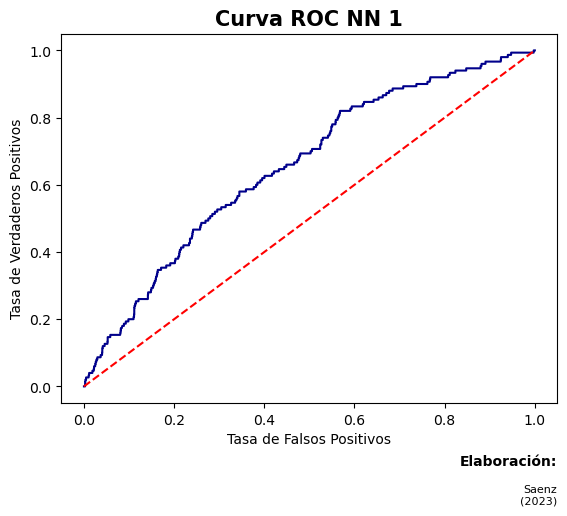

In [107]:
NN_roc_auc = roc_auc_score(y_test, pred_NN[0])
FP, VP, umbral = roc_curve(y_test, pred_NN[0])
fig, ax = plt.subplots()
ax.plot(FP, VP, color = "darkblue")
ax.plot([0,1], [0,1], linestyle = "--", color = "red")
ax.set_xlabel("Tasa de Falsos Positivos")
ax.set_ylabel("Tasa de Verdaderos Positivos")
ax.set_title("Curva ROC NN 1", fontweight = "bold", size = 15)
fig.text(.9,-.02, "Elaboración:", fontsize = 10, fontweight = "bold",
         ha = "right")
fig.text(.9,-.1, "Saenz\n(2023)", fontsize = 8, ha = "right")
plt.show()

### Segunda red neuronal: Entrenada con una grilla de parámetros, número de capas ocultas y neuronas

In [108]:
#Crear el conjunto de validación para la red neuronal
X_train_scaled = pd.DataFrame(X_train_scaled)
y_train = pd.DataFrame(y_train)
X_train2, X_val, y_train2, y_val = train_test_split(X_train_scaled, 
                                                    y_train['default'],
                                                    test_size=0.2, random_state=13)
X_train2.shape, X_val.shape, y_train2.shape, y_val.shape

((4881, 24), (1221, 24), (4881,), (1221,))

In [109]:
# This returns a multi-layer-perceptron model in Keras.
def get_keras_model(num_hidden_layers, 
                    num_neurons_per_layer, 
                    dropout_rate, 
                    activation):
    # create the MLP model.
    
    # define the layers.
    inputs = tf.keras.Input(shape=(X_train2.shape[1],))  # input layer.
    x = layers.Dropout(dropout_rate)(inputs) # dropout on the weights.
    
    # Add the hidden layers.
    for i in range(num_hidden_layers):
        x = layers.Dense(num_neurons_per_layer, 
                         activation=activation)(x)
        x = layers.Dropout(dropout_rate)(x)
    
    # output layer.
    outputs = layers.Dense(1, activation='sigmoid')(x) #Binary classification
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [110]:
# This function takes in the hyperparameters and returns a score (Cross validation).
def keras_mlp_cv_score(parameterization, weight=None):
    
    model = get_keras_model(parameterization.get('num_hidden_layers'),
                            parameterization.get('neurons_per_layer'),
                            parameterization.get('dropout_rate'),
                            parameterization.get('activation'))
    
    opt = parameterization.get('optimizer')
    opt = opt.lower()
    
    learning_rate = parameterization.get('learning_rate')
    
    if opt == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif opt == 'rms':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    NUM_EPOCHS = 20
    
    # Specify the training configuration.
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    data = X_train2
    labels = y_train2
    
    # fit the model using validation_data=(X_val,y_val) validation set.
    res = model.fit(data, labels, epochs=NUM_EPOCHS, 
                    batch_size=parameterization.get('batch_size'),
                    validation_data=(X_val,y_val))
    
    # look at the last 10 epochs. Get the mean and standard deviation of the
    #validation score.
    last10_scores = np.array(res.history['val_loss'][-10:])
    mean = last10_scores.mean()
    sem = last10_scores.std()
    
    # If the model didn't converge then set a high loss.
    if np.isnan(mean):
        return 9999.0, 0.0
    
    return mean, sem

In [111]:
# Define the search space.
parameters=[
    {
        "name": "learning_rate",
        "type": "range",
        "bounds": [0.001, 0.002],
        "log_scale": True,
    },
    {
        "name": "dropout_rate",
        "type": "range",
        "bounds": [0.01, 0.02],
        "log_scale": True,
    },
    {
        "name": "num_hidden_layers",
        "type": "range",
        "bounds": [1, 3],
        "value_type": "int"
    },
    {
        "name": "neurons_per_layer",
        "type": "range",
        "bounds": [16, 32],
        "value_type": "int"
    },
    {
        "name": "batch_size",
        "type": "choice",
        "values": [16, 32],
    },
    
    {
        "name": "activation",
        "type": "choice",
        "values": ['tanh', 'sigmoid', 'relu'],
    },
    {
        "name": "optimizer",
        "type": "choice",
        "values": ['adam', 'rms'],
    },
]

In [ ]:
init_notebook_plotting()
ax_client = AxClient()
# create the experiment.
ax_client.create_experiment(
    name="keras_experiment",
    parameters=parameters,
    objective_name='keras_cv',
    minimize=True)
def evaluate(parameters):
    return {"keras_cv": keras_mlp_cv_score(parameters)}

In [ ]:
for i in range(20):
    parameters, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

In [114]:
ax_client.get_trials_data_frame().sort_values('trial_index')

,keras_cv,trial_index,arm_name,learning_rate,dropout_rate,num_hidden_layers,neurons_per_layer,batch_size,activation,optimizer,trial_status,generation_method
0,0.295490,0,0_0,0.001537,0.014869,2,27,32,relu,adam,COMPLETED,Sobol
1,0.288199,1,1_0,0.001219,0.012949,1,17,32,tanh,adam,COMPLETED,Sobol
2,0.295478,2,2_0,0.001692,0.017752,2,26,16,relu,rms,COMPLETED,Sobol
3,0.289119,3,3_0,0.001663,0.011334,2,16,16,sigmoid,adam,COMPLETED,Sobol
4,0.292480,4,4_0,0.001177,0.015526,1,30,16,relu,adam,COMPLETED,Sobol
5,0.287949,5,5_0,0.001099,0.017573,3,20,16,tanh,adam,COMPLETED,Sobol
6,0.289914,6,6_0,0.001182,0.012700,1,22,32,sigmoid,adam,COMPLETED,Sobol
7,0.293738,7,7_0,0.001298,0.013025,2,16,16,relu,adam,COMPLETED,Sobol
8,0.288137,8,8_0,0.001385,0.019874,2,21,32,tanh,adam,COMPLETED,Sobol
9,0.296888,9,9_0,0.001088,0.013948,2,24,16,relu,adam,COMPLETED,Sobol


In [115]:
best_parameters, values = ax_client.get_best_parameters()
# the best set of parameters.
for k in best_parameters.items():
  print(k)
print()
# the best score achieved.
means, covariances = values
print(means)

[WARNING 09-01 20:26:51] ax.modelbridge.cross_validation: Metric keras_cv was unable to be reliably fit.
[WARNING 09-01 20:26:51] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 09-01 20:26:51] ax.service.utils.best_point: Model fit is poor and data on objective metric keras_cv is noisy; interpret best points results carefully.


('learning_rate', 0.00130066437976216)
('dropout_rate', 0.01944831527774094)
('num_hidden_layers', 2)
('neurons_per_layer', 21)
('batch_size', 16)
('activation', 'tanh')
('optimizer', 'adam')

{'keras_cv': 0.28789081871509553}


In [116]:
#### Construyendo la red con los parámetros que arrojó
model_RNN = tf.keras.Sequential([
    tf.keras.layers.Dense(8, input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.017389321921969042),
    tf.keras.layers.Dense(17, activation='relu'),
    tf.keras.layers.Dropout(0.017389321921969042),
    tf.keras.layers.Dense(17, activation='relu'),
    tf.keras.layers.Dropout(0.017389321921969042),
    tf.keras.layers.Dense(17, activation='relu'),
    tf.keras.layers.Dropout(0.017389321921969042),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model_RNN.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model_RNN.fit(X_train_scaled, y_train, epochs=20, batch_size=16,
           validation_data=(X_val,y_val))

Epoch 1/20
382/382 [==============================] - 4s 4ms/step - loss: 0.3746 - accuracy: 0.8856 - val_loss: 0.3064 - val_accuracy: 0.9099
Epoch 2/20
382/382 [==============================] - 2s 4ms/step - loss: 0.3081 - accuracy: 0.9094 - val_loss: 0.2977 - val_accuracy: 0.9099
Epoch 3/20
382/382 [==============================] - 1s 4ms/step - loss: 0.2990 - accuracy: 0.9092 - val_loss: 0.2900 - val_accuracy: 0.9099
Epoch 4/20
382/382 [==============================] - 1s 4ms/step - loss: 0.2919 - accuracy: 0.9092 - val_loss: 0.2870 - val_accuracy: 0.9099
Epoch 5/20
382/382 [==============================] - 2s 5ms/step - loss: 0.2915 - accuracy: 0.9089 - val_loss: 0.2838 - val_accuracy: 0.9099
Epoch 6/20
382/382 [==============================] - 2s 5ms/step - loss: 0.2897 - accuracy: 0.9090 - val_loss: 0.2833 - val_accuracy: 0.9099
Epoch 7/20
382/382 [==============================] - 2s 6ms/step - loss: 0.2861 - accuracy: 0.9092 - val_loss: 0.2818 - val_accuracy: 0.9099
Epoch 

In [117]:
model_RNN.evaluate(X_test_scaled, y_test) # La precisión es la misma que la primera red

65/65 [==============================] - 0s 2ms/step - loss: 0.2581 - accuracy: 0.9275


[0.2580638825893402, 0.9274661540985107]

In [118]:
pred_RNN = model_RNN.predict(X_test_scaled)
pred_RNN = pd.DataFrame(pred_RNN)
pred_RNN['Grupo_de_Riesgo'] = pd.cut(pred_RNN[0], bins, labels = names)
pred_RNN['Grupo_de_Riesgo'].value_counts().sort_index()

65/65 [==============================] - 0s 2ms/step


T1     92
T2     58
T3    195
T4    231
T5    615
T6    623
T7    250
T8      4
Name: Grupo_de_Riesgo, dtype: int64

In [119]:
## Estos son los resultados de la segunda red neuronal por grupo de riesgo.

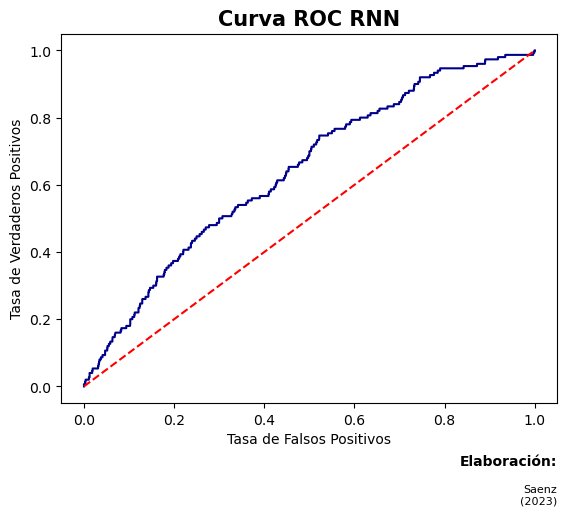

In [120]:
RNN_roc_auc = roc_auc_score(y_test, pred_RNN.iloc[:,0])
FP, VP, umbral = roc_curve(y_test, pred_RNN.iloc[:,0])
fig, ax = plt.subplots()
ax.plot(FP, VP, color = "darkblue")
ax.plot([0,1], [0,1], linestyle = "--", color = "red")
ax.set_xlabel("Tasa de Falsos Positivos")
ax.set_ylabel("Tasa de Verdaderos Positivos")
ax.set_title("Curva ROC RNN", fontweight = "bold", size = 15)
fig.text(.9,-.02, "Elaboración:", fontsize = 10, fontweight = "bold",
         ha = "right")
fig.text(.9,-.1, "Saenz\n(2023)", fontsize = 8, ha = "right")
plt.show()

### Comparación de modelos

In [121]:
score_1NN = model.evaluate(X_test_scaled, y_test)[1]
score_2NN = model_RNN.evaluate(X_test_scaled, y_test)[1]

65/65 [==============================] - 0s 2ms/step - loss: 0.2581 - accuracy: 0.9275


In [122]:
score_lr, score_rf, score_knn, score_svm, score_1NN, score_2NN

(0.9264990328820116,
 0.9264990328820116,
 0.9260154738878144,
 0.9274661508704062,
 0.926982581615448,
 0.9274661540985107)

In [123]:
# Por precisión es mejor la red neuronal, cualquiera de las dos. Seguido de el Support Vector Machine y de tercero el Random Forest.

In [124]:
prob_incum_logistic['Grupo_de_Riesgo'].value_counts().sort_index()

T1     51
T2     41
T3    131
T4    196
T5    679
T6    714
T7    252
T8      4
Name: Grupo_de_Riesgo, dtype: int64

In [125]:
prob_incum_rf['Grupo_de_Riesgo'].value_counts().sort_index()

T1     85
T2     53
T3    202
T4    200
T5    500
T6    687
T7    326
T8     15
Name: Grupo_de_Riesgo, dtype: int64

In [126]:
prob_incum_knn['Grupo_de_Riesgo'].value_counts().sort_index()

T1      0
T2      0
T3      0
T4      0
T5    664
T6    389
T7    196
T8     45
Name: Grupo_de_Riesgo, dtype: int64

In [129]:
prob_incum_svm['Grupo_de_Riesgo'].value_counts().sort_index()

In [128]:
pred_NN['Grupo_de_Riesgo'].value_counts().sort_index()

T1     55
T2     33
T3    139
T4    251
T5    660
T6    651
T7    273
T8      6
Name: Grupo_de_Riesgo, dtype: int64

In [130]:
pred_RNN['Grupo_de_Riesgo'].value_counts().sort_index()

T1     92
T2     58
T3    195
T4    231
T5    615
T6    623
T7    250
T8      4
Name: Grupo_de_Riesgo, dtype: int64

Los modelos de KNN y SVM quedan excluidos porque no clasificaron en todos los grupos de riesgos. Se escoge la segunda red neuronal ya que presentó una precisión alta y además se estimó teniendo en cuenta una amplia grilla de parámetros y también penalización por Dropout.

In [131]:
pred_RNN.rename(columns = {0:'Probabilidad', 'Grupo_de_Riesgo':'grupo_riesgo'}, inplace = True)
pred_RNN

,Probabilidad,grupo_riesgo
0,0.015339,T3
1,0.008227,T1
2,0.044656,T4
3,0.086790,T6
4,0.151853,T7
...,...,...
2063,0.027600,T3
2064,0.019957,T3
2065,0.134404,T6
2066,0.072088,T5


In [133]:
num_doc_prueba = pd.DataFrame(num_doc_prueba)
num_doc_prueba

,num_doc
0,9.540607e+09
1,4.738860e+10
2,3.407610e+11
3,3.925603e+11
4,3.985404e+11
...,...
2063,4.065446e+11
2064,4.402110e+11
2065,5.226720e+11
2066,5.707172e+11


In [134]:
pred_grupo_riesgo_valid = pd.concat([num_doc_prueba, pred_RNN], axis=1)
pred_grupo_riesgo_valid

,num_doc,Probabilidad,grupo_riesgo
0,9.540607e+09,0.015339,T3
1,4.738860e+10,0.008227,T1
2,3.407610e+11,0.044656,T4
3,3.925603e+11,0.086790,T6
4,3.985404e+11,0.151853,T7
...,...,...,...
2063,4.065446e+11,0.027600,T3
2064,4.402110e+11,0.019957,T3
2065,5.226720e+11,0.134404,T6
2066,5.707172e+11,0.072088,T5


## Análisis para el conjunto de prueba

In [ ]:
base_prueba = pd.read_csv('base_prueba.csv', sep ='|')
base_prueba

In [148]:
base_prueba = base_prueba.loc[(base_prueba['tipo_cliente']=='objetivo')]
num_doc_prueba2 = base_prueba['num_doc']
base_prueba = base_prueba.drop(['num_doc', 'f_analisis', 'tipo_cliente'], axis=1)
base_prueba

,trx39,trx102,trx106,trx143,trx158,disp309,CO01END010RO,CO01ACP017CC,CO02EXP011TO,CO02EXP004TO,...,CO01END086RO,CO01END094RO,CO02NUM086AH,CO02NUM043RO,CO01EXP002AH,CO01NUM002AH,CO01END051RO,CO01ACP011RO,CO02MOR092TO,CO01MOR098RO
0,0.986013,0.000000,0.000022,0.140096,0.461207,7.0,-1.00,39.0,100.00,15.0,...,-1.00,-1.00,25.00,-1.0,15.0,1.0,-1.00,-1.0,100.0,-1.0
3,0.372678,0.000000,0.000005,0.000000,0.069334,7.0,1.05,-1.0,66.67,10.0,...,34.82,2.42,66.67,0.0,11.0,2.0,1.92,-2.0,-3.0,-3.0
4,1.089725,0.000000,0.000000,0.186817,0.118401,11.0,-2.00,-2.0,75.00,10.0,...,-3.00,-2.00,50.00,100.0,10.0,2.0,-3.00,0.0,100.0,-3.0
5,0.000000,0.000000,0.000000,0.026700,0.000000,6.0,0.33,-2.0,100.00,0.0,...,92.62,2.54,33.33,50.0,0.0,4.0,2.68,0.0,100.0,-3.0
7,1.280191,0.000000,0.000001,0.382554,0.196148,12.0,-1.00,61.0,100.00,8.0,...,-1.00,-1.00,50.00,-1.0,11.0,1.0,-1.00,-1.0,-3.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5868,3.578485,0.000006,0.000000,0.553695,0.130235,8.0,-1.00,39.0,33.33,2.0,...,-1.00,-1.00,50.00,-1.0,2.0,5.0,-1.00,-1.0,0.0,-1.0
5874,0.276385,0.000000,0.000000,0.017689,0.004267,11.0,-1.00,-2.0,100.00,2.0,...,-1.00,-1.00,33.33,-1.0,2.0,1.0,-1.00,-1.0,-3.0,-1.0
5882,0.276385,0.000001,0.000000,0.000000,0.021334,12.0,-1.00,-1.0,-4.00,96.0,...,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0
5886,0.372678,0.000028,0.000032,0.000000,0.020488,8.0,-1.00,8.0,66.67,2.0,...,-1.00,-1.00,66.67,-1.0,2.0,2.0,-1.00,-1.0,-3.0,-1.0


In [150]:
# Escalar variables
scaler = StandardScaler()
base_prueba_scaled = scaler.fit_transform(base_prueba)
print(base_prueba_scaled)

[[ 0.47862748 -0.11093923 -0.12743426 ... -0.38659358  0.70165659
  -0.78981634]
 [-0.2318512  -0.11093923 -0.12776231 ... -1.12053689 -1.57748366
  -0.83143071]
 [ 0.59876537 -0.11093923 -0.12786325 ...  0.34734974  0.70165659
  -0.83143071]
 ...
 [-0.34339512 -0.11091878 -0.12786325 ... -0.38659358 -1.53322851
  -0.78981634]
 [-0.2318512  -0.11046894 -0.12723238 ... -0.38659358 -1.57748366
  -0.78981634]
 [-0.66355593 -0.11083699 -0.12776231 ... -1.12053689  0.70165659
  -0.81062352]]


In [151]:
pd.DataFrame(base_prueba_scaled)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.478627,-0.110939,-0.127434,0.219555,1.983358,0.082047,-0.508765,0.865011,0.668663,0.900077,...,-0.734984,-0.514134,-0.661756,-0.768903,0.385724,-0.899672,-0.332481,-0.386594,0.701657,-0.789816
1,-0.231851,-0.110939,-0.127762,-0.430960,-0.105325,0.082047,0.116568,-0.524592,-0.684393,0.466085,...,0.162886,-0.101167,0.964219,-0.740463,0.143285,-0.102483,0.002078,-1.120537,-1.577484,-0.831431
2,0.598765,-0.110939,-0.127863,0.436499,0.156203,1.219283,-0.813806,-0.559332,-0.346231,0.466085,...,-0.785116,-0.634884,0.313751,2.103616,0.082675,-0.102483,-0.561632,0.347350,0.701657,-0.831431
3,-0.663556,-0.110939,-0.127863,-0.306981,-0.474875,-0.202262,-0.103061,-0.559332,0.668663,-0.401900,...,1.611711,-0.086677,-0.336717,0.681577,-0.523424,1.491896,0.089155,0.347350,0.701657,-0.831431
4,0.819399,-0.110939,-0.127838,1.345379,0.570593,1.503592,-0.508765,1.629292,0.668663,0.292488,...,-0.734984,-0.514134,0.313751,-0.768903,0.143285,-0.899672,-0.332481,-0.386594,-1.577484,-0.789816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,3.481709,-0.110837,-0.127863,2.140046,0.219279,0.366356,-0.508765,0.865011,-2.037855,-0.228303,...,-0.734984,-0.514134,0.313751,-0.768903,-0.402204,2.289085,-0.332481,-0.386594,-1.511101,-0.789816
2633,-0.343395,-0.110939,-0.127863,-0.348824,-0.452133,1.219283,-0.508765,-0.559332,0.668663,-0.228303,...,-0.734984,-0.514134,-0.336717,-0.768903,-0.402204,-0.899672,-0.332481,-0.386594,-1.577484,-0.789816
2634,-0.343395,-0.110919,-0.127863,-0.430960,-0.361167,1.503592,-0.508765,-0.524592,-3.553295,7.930753,...,-0.734984,-0.514134,-1.676282,-0.768903,-0.584034,-2.494050,-0.332481,-0.386594,-1.533229,-0.789816
2635,-0.231851,-0.110469,-0.127232,-0.430960,-0.365672,0.366356,-0.508765,-0.211932,-0.684393,-0.228303,...,-0.734984,-0.514134,0.964219,-0.768903,-0.402204,-0.102483,-0.332481,-0.386594,-1.577484,-0.789816


In [152]:
model_RNN # Se usa este modelo ya que fue el que obtuvo mejor ajuste y precisión

In [153]:
bins = [0, 0.010, 0.015, 0.030, 0.045, 0.080, 0.150, 0.300, 1.0]
names = ["T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8"]

In [154]:
pred_RNN_prueba = model_RNN.predict(base_prueba_scaled)
pred_RNN_prueba = pd.DataFrame(pred_RNN_prueba)
pred_RNN_prueba['grupo_riesgo'] = pd.cut(pred_RNN_prueba[0], bins, labels = names)
pred_RNN_prueba['grupo_riesgo'].value_counts().sort_index()

83/83 [==============================] - 0s 2ms/step


T1    141
T2     65
T3    253
T4    318
T5    705
T6    782
T7    362
T8     11
Name: grupo_riesgo, dtype: int64

In [155]:
## Estos son los resultados de la segunda red neuronal por grupo de riesgo, aplicado al conjunto de prueba

In [156]:
pred_RNN_prueba.rename(columns = {0:'Probabilidad'}, inplace = True)
pred_RNN_prueba

,Probabilidad,grupo_riesgo
0,0.043629,T4
1,0.085849,T6
2,0.091470,T6
3,0.143399,T6
4,0.074942,T5
...,...,...
2632,0.081609,T6
2633,0.123583,T6
2634,0.002182,T1
2635,0.106141,T6


In [ ]:
num_doc_prueba2 = pd.DataFrame(num_doc_prueba2)
num_doc_prueba2 = num_doc_prueba2.reset_index(drop=True)
num_doc_prueba2

In [180]:
pred_RNN_prueba = pred_RNN_prueba.reset_index(drop=True)
base_prueba = base_prueba.reset_index(drop=True)
pred_grupo_riesgo_prueba = pd.concat([pred_RNN_prueba, base_prueba], axis=1, ignore_index=True)
pred_grupo_riesgo_prueba.columns = pred_RNN_prueba.columns.tolist() + base_prueba.columns.tolist()
pred_grupo_riesgo_prueba

,Probabilidad,grupo_riesgo,trx39,trx102,trx106,trx143,trx158,disp309,CO01END010RO,CO01ACP017CC,...,CO01END086RO,CO01END094RO,CO02NUM086AH,CO02NUM043RO,CO01EXP002AH,CO01NUM002AH,CO01END051RO,CO01ACP011RO,CO02MOR092TO,CO01MOR098RO
0,0.043629,T4,0.986013,0.000000,0.000022,0.140096,0.461207,7.0,-1.00,39.0,...,-1.00,-1.00,25.00,-1.0,15.0,1.0,-1.00,-1.0,100.0,-1.0
1,0.085849,T6,0.372678,0.000000,0.000005,0.000000,0.069334,7.0,1.05,-1.0,...,34.82,2.42,66.67,0.0,11.0,2.0,1.92,-2.0,-3.0,-3.0
2,0.091470,T6,1.089725,0.000000,0.000000,0.186817,0.118401,11.0,-2.00,-2.0,...,-3.00,-2.00,50.00,100.0,10.0,2.0,-3.00,0.0,100.0,-3.0
3,0.143399,T6,0.000000,0.000000,0.000000,0.026700,0.000000,6.0,0.33,-2.0,...,92.62,2.54,33.33,50.0,0.0,4.0,2.68,0.0,100.0,-3.0
4,0.074942,T5,1.280191,0.000000,0.000001,0.382554,0.196148,12.0,-1.00,61.0,...,-1.00,-1.00,50.00,-1.0,11.0,1.0,-1.00,-1.0,-3.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,0.081609,T6,3.578485,0.000006,0.000000,0.553695,0.130235,8.0,-1.00,39.0,...,-1.00,-1.00,50.00,-1.0,2.0,5.0,-1.00,-1.0,0.0,-1.0
2633,0.123583,T6,0.276385,0.000000,0.000000,0.017689,0.004267,11.0,-1.00,-2.0,...,-1.00,-1.00,33.33,-1.0,2.0,1.0,-1.00,-1.0,-3.0,-1.0
2634,0.002182,T1,0.276385,0.000001,0.000000,0.000000,0.021334,12.0,-1.00,-1.0,...,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0
2635,0.106141,T6,0.372678,0.000028,0.000032,0.000000,0.020488,8.0,-1.00,8.0,...,-1.00,-1.00,66.67,-1.0,2.0,2.0,-1.00,-1.0,-3.0,-1.0


In [181]:
pred_grupo_riesgo_prueba.to_csv('base_prueba.csv', sep ='|', index=False)